In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from sklearn.manifold import TSNE
%matplotlib inline

In [5]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

****
### MAIN INVESTIGATIONS
#### STATEMENT
    [ ] word_id_custom
    [ ] word_id_spacy
    [ ] GloVe

#### POS
    [ ] pos_id
    [ ] pos_id_default

### EXTRA INVESTIGATIONS
#### DEP
    [ ] dep_id

#### META
    [ ] subject_id
    [ ] speaker_id
    [ ] job_id
    [ ] state_id
    [ ] party_id
    [ ] context_id


#### EXPORTS
*UPDATE TO 2 apr*

    [ ] train_data, test_data, val_data AS CSV
    [ ] embedding_matrix.npy
    [ ] vocabulary_statement_custom.p
    [ ] pos_dict.values(), dep_dict.values()
    [ ] pos_embeddings, dep_embeddings


### Sunday 12 March DONE [x]


    


TO DO FOR the WEEK: <br>
    - add function to remove stopwords from pos_id X
1. og statement -> get pos -> pos_id
	- train_data['pos_id'] = train_data['statement'].apply(get_pos)

2. og statement -> # preprocess statement: words lemmatized and stopwords are removed -> pred_statement
	- train_data['pred_statement'] = train_data['statement'].apply(preprocess_statement)

3. pred_statement -> add to vocab dict: add preprocessed statements to vocab dict -> vocab_dict
	- vocabulary_dict = load_statement_vocab_dict(train_data)

4. vocab_dict, pred_statement -> getWordID(): turn preprocessed statements to vector -> val
	- train_data['word_id'] = train_data['pred_statement'].apply(lambda x: getWordId(x, vocabulary_dict)

**NOTE** it is generally fine to add pos tags without stopwords removed.
	in siddarthhari, padding used to put pos tags as separate input layer.

15 mar: <br>
    - extracted getWordId() from preprocess_statement()

### 19 March DONE


TODO: 
1. POS tags - incorporate stop words into pos tags 
- update: no need since separate input.
2. preprocess_statement() - configure best ones. confirm lemmatizer works

# Headers

## Header 1 
### Header 2

#### Styles
*Italic*, **bold**, _underscore_, ~~strikethrough~~

#### Hyperlink
[hyperlink](https://www.markdownguide.org/)

#### Table
| Default | Left-aligned | Center-aligned | Right-aligned |
|---------|:-------------|:--------------:|--------------:|
| Default | Left | Center | Right |

#### Others
* Bulleted item 1
    * Bulleted subitem 1
* Bulleted item 2

***
    1. Ordered item 1
        1.1. Ordered subitem 1
    2. Ordered item 2

***
    [ ] Unchecked box
    [x] Checked box

# Preprocessing

## Functions

    ADJ: Adjective - a word that describes a noun or pronoun. Examples: "red", "happy", "big"
    ADP: Adposition - a word that expresses a relationship between a noun or pronoun and other words in a sentence. Examples: "in", "on", "at"
    ADV: Adverb - a word that modifies a verb, adjective, or other adverb. Examples: "quickly", "very", "well"
    AUX: Auxiliary verb - a verb used in combination with a main verb to express tense, aspect, modality, or voice. Examples: "is", "have", "will"
    CONJ: Coordinating conjunction - a word that connects words, phrases, or clauses of equal importance. Examples: "and", "or", "but"
    DET: Determiner - a word that introduces a noun and provides information about the quantity or identity of the noun. Examples: "the", "a", "some"
    INTJ: Interjection - a word or phrase that expresses strong emotion or surprise. Examples: "oh", "wow", "ouch"
    NOUN: Noun - a word that refers to a person, place, thing, or idea. Examples: "dog", "house", "happiness"
    NUM: Numeral - a word that represents a number or quantity. Examples: "one", "two", "hundred"
    PART: Particle - a word that functions as an auxiliary to a verb or as a discourse marker. Examples: "not", "to", "up"
    PRON: Pronoun - a word that takes the place of a noun or noun phrase. Examples: "he", "she", "it"
    PROPN: Proper noun - a noun that refers to a specific person, place, or thing. Examples: "New York", "John", "Nike"
    PUNCT: Punctuation - a character or mark used in writing to separate sentences, clauses, or phrases, or to indicate pauses or intonation. Examples: ".", ",", "!"
    X: Other - a catch-all category for words that don't fit into any other part-of-speech category. Examples: foreign words, abbreviations, etc.
    SCONJ: Subordinating conjunction - a word that connects a dependent clause to an independent clause. Examples: "although", "because", "unless"
    SYM: Symbol - a character or glyph that represents a specific meaning or concept. Examples: "$", "%", "#"
    VERB: Verb - a word that describes an action or state of being. Examples: "run", "think", "be"

In [6]:
pos_tags = { 'ADJ': 'adjective', 'ADP': 'adposition', 'ADV': 'adverb', 'AUX': 'auxiliary verb', 'CONJ': 'coordinating conjunction',
                    'DET': 'determiner', 'INTJ': 'interjection', 'NOUN': 'noun',  'NUM': 'numeral', 'PART': 'particle', 'PRON': 'pronoun',
                    'PROPN': 'proper noun', 'PUNCT': 'punctuation', 'X': 'other', 'SCONJ': 'subordinating conjunction', 'SYM': 'symbol', 'VERB': 'verb'}

# proposed pos_dict: values correspond to pos tag importance
pos_dict_custom = {'NOUN': 0, 'VERB': 1, 'ADJ': 2, 'ADV': 3, 'ADP': 4, 'PRON': 5,
                    'NUM': 6, 'SCONJ': 7, 'PROPN': 8, 'CONJ': 9, 'PUNCT': 10, 'AUX': 11,
                    'PART': 12, 'INTJ': 13, 'DET': 14, 'SYM': 14, 'X': 14}

pos_dict_default = {'ADJ': 0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CONJ': 4,
            'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9,
            'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'X': 13,  'SCONJ': 14, 'SYM': 15, 'VERB': 16}

# save dictionaries
with open('pos_dicts.pickle', 'wb') as f:
    pickle.dump((pos_dict_custom, pos_dict_default), f)

In [7]:
from collections import defaultdict

def get_pos(statement, pos_dict):
    # create a defaultdict object that returns max(pos_dict.values())+1
    # as the default value for any key (POS label) that is not found
    tag_dict = defaultdict(lambda: max(pos_dict.values())+1, pos_dict)
    tag_list = [tag_dict[token.pos_] for token in nlp(statement)]
    return tag_list


In [8]:
def preprocess_statement(statement, pos_remove=None, spacy_stopword_removal=False):
# lemmatizes and lowercases tokens that are not punctuation or whitespace.
# params: statement - string
#         exclude_pos - list of POS tags to exclude from word list
#         remove_stopwords - removes stopwords based on pretrained spacy model
#         **warning** not recommended to toggle both params to True
# returns: tokens joined into a string
    doc = nlp(statement)
    words = []
    for token in doc:
        # check if token should be excluded based on part of speech or stopword status
        if pos_remove and token.pos_ in pos_remove:
            continue
        if spacy_stopword_removal and token.is_stop:
            continue
        # only include tokens that are not punctuation or whitespace
        if not token.is_punct and not token.is_space:
            # lemmatize and lowercase
            words.append(token.lemma_.lower())
    return ' '.join(words)

In [9]:
def preprocess_statement(statement, pos_remove=None, spacy_stopword_removal=False):
    # lemmatizes and lowercases tokens that are not punctuation or whitespace.
    # params: statement - string
    # exclude_pos - list of POS tags to exclude from word list
    # remove_stopwords - removes stopwords based on pretrained spacy model
    # **warning** not recommended to toggle both params to True
    # returns: tokens joined into a string

    words = (token.lemma_.lower() for token in nlp(statement)
             if not token.is_punct and not token.is_space and
             (not pos_remove or token.pos_ not in pos_remove) and
             (not spacy_stopword_removal or not token.is_stop))

    return ' '.join(words)


In [10]:
def create_statement_vocab_dict(data, column_name):
    vocab_file_name = f"vocabulary_{column_name}.p"

    if os.path.exists(vocab_file_name):
        with open(vocab_file_name, "rb") as f:
            old_vocabulary_dict = pickle.load(f)
        # Check length of existing vocabulary dictionary and length of vocabulary dictionary created from the text data
        if len(old_vocabulary_dict) == len(set(data[column_name].str.split().sum())):
            print(f"Using existing Vocabulary Dictionary for column {column_name}...")
            return old_vocabulary_dict

        # If the length is different, delete the existing vocabulary dictionary file
        else:
            os.remove(vocab_file_name)
            print(f"Deleted existing Vocabulary Dictionary for column {column_name}...")

    # Create a new tokenizer object and fit it on the text data for the specified column
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data[column_name])

    vocabulary_dict = tokenizer.word_index
    print(f"Created Vocabulary Dictionary for column {column_name}.")
    print('Size: ' + str(len(vocabulary_dict)))

    # Save the vocabulary dictionary to a file
    with open(vocab_file_name, "wb") as f:
        pickle.dump(vocabulary_dict, f)
    print(f"Saved Vocabulary Dictionary as {vocab_file_name}")
    return vocabulary_dict

vocabulary_dict_spacy = create_statement_vocab_dict(train_data, 'statement_spacy')

In [11]:
# preprocessed statement to vector
def getWordId(pred_statement, vocabulary_dict):
    text = text_to_word_sequence(pred_statement)
    val = [vocabulary_dict[t] for t in text if t in vocabulary_dict]
    return val

In [12]:
def print_row_info(row_num, df):
    print(f"#### label #####\n{df.loc[row_num, 'label']}")
    print(f"#### original statement #####\n{df.loc[row_num, 'statement']}")
    print(f"#### pos_id #####\n{df.loc[row_num, 'pos_id']}")
    print(f"#### custom stopwords #####\n{df.loc[row_num, 'statement_custom']}")
    print(f"#### word_id #####\n{df.loc[row_num, 'word_id_custom']}")
    print(f"#### spacy stopwords #####\n{df.loc[row_num, 'statement_spacy']}")
    print(f"#### spacy word_id #####\n{df.loc[row_num, 'word_id_spacy']}")

In [19]:
def clean_data(data, label_map):
    # maps labels to numerical values to 'output' column
    data['output'] = data['label'].apply(lambda x: label_map[x])

    # replace missing values with empty strings
    data['subject'] = data['subject'].fillna('')
    data['speaker'] = data['speaker'].fillna('')
    data['job_title'] = data['job_title'].fillna('')
    data['state_info'] = data['state_info'].fillna('')
    data['party'] = data['party'].fillna('')
    data['context'] = data['context'].fillna('')

    # drop rows where there are missing values in 'statement'
    data.drop(index=data[data.statement==' '].index, inplace=True)
    data.drop(index=data[data.statement=='  '].index, inplace=True)
    data.drop(index=data[data.statement=='\n'].index, inplace=True)

    # drop context column
    # data.drop(columns=['context'], inplace=True)
    # data.drop(columns=['id'], inplace=True)
    # data.drop(columns=['state info'], inplace=True)
    # data.drop(columns=['party'], inplace=True)

    # reset index
    data = data.reset_index()

    return data

## DataFrame Cleaning

- train_data['label'] -> num values
- drops all rows where 'subject' and 'speaker' columns are missing
- drops all rows that have missing values in 'statement'
- drops context column

<h3>Mar 19 todo:</h3>

- refactor to single function
- instead of dropping rows, replace missing values in 'subject' and 'speaker' as empty string

In [53]:
# column titles and label maps
columns = ['id','label','statement','subject','speaker','job_title','state_info','party','barely true','false','half-true','mostly-true','pants-on-fire','context']
label_map = {'pants-fire':-3, 'false':-2, 'barely-true':-1, 'half-true':1, 'mostly-true':2, 'true':3}

In [54]:
# load dataset files as pandas dataframes
train_data = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)
val_data = pd.read_csv('valid.tsv', sep='\t', header=None, names=columns)
test_data = pd.read_csv('test.tsv', sep='\t', header=None, names=columns)
# train_data.head()

In [55]:
train_data = clean_data(train_data, label_map)
val_data = clean_data(val_data, label_map)
test_data = clean_data(test_data, label_map)

In [56]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                                      none   
4                                                       Florida    democrat   
...                                              ...        ...         ...   
10235                                                   Florida        none   
10236                                                   Georgia  republican   
10237                                                   Georgia  republican   
10238                                                   Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  false  half-true  mostly-true  pants-on-fire  \
0              0.0    1.0        0.0          0.0            0.0   
1              0.0    0.0        1.0          1.0            0.0   
2             70.0   71.0      160.0        163.0            9.0   
3              7.0   19.0        3.0          5.0           44.0   
4             15.0    9.0       20.0         19.0            2.0   
...            ...    ...        ...          ...            ...   
10235          0.0    1.0        1.0          1.0            0.0   
10236          0.0    0.0        0.0          1.0            0.0   
10237          4.0   11.0        5.0          3.0            3.0   
10238          3.0    1.0        3.0          0.0            0.0   
10239          0.0    1.0        1.0          0.0            2.0   

                                                 context  output  
0                                               a mailer      -2  
1                                        a floor speech.       1  
2                                                 Denver       2  
3                         

In [72]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                NaN        NaN        none   
4                                                NaN    Florida    democrat   
...                                              ...        ...         ...   
10235                                            NaN    Florida        none   
10236                                            NaN    Georgia  republican   
10237                                            NaN    Georgia  republican   
10238                                            NaN    Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  false  half-true  mostly-true  pants-on-fire  \
0              0.0    1.0        0.0          0.0            0.0   
1              0.0    0.0        1.0          1.0            0.0   
2             70.0   71.0      160.0        163.0            9.0   
3              7.0   19.0        3.0          5.0           44.0   
4             15.0    9.0       20.0         19.0            2.0   
...            ...    ...        ...          ...            ...   
10235          0.0    1.0        1.0          1.0            0.0   
10236          0.0    0.0        0.0          1.0            0.0   
10237          4.0   11.0        5.0          3.0            3.0   
10238          3.0    1.0        3.0          0.0            0.0   
10239          0.0    1.0        1.0          0.0            2.0   

                                                 context  output  
0                                               a mailer      -2  
1                                        a floor speech.       1  
2                                                 Denver       2  
3                         

In [23]:
print('real news count')
train_data[train_data['output']>0].count()

real news count


index            5752
id               5752
label            5752
statement        5752
subject          5752
speaker          5752
job_title        5752
state_info       5752
party            5752
barely true      5752
false            5752
half-true        5752
mostly-true      5752
pants-on-fire    5752
context          5752
output           5752
dtype: int64

### for this experiment, siddarth's results will be used as benchmark.


## META DATA PREPARATION

### Functions


In [57]:
import re

def preprocess_meta_label(label):
    label = label.lower()
    label = re.sub(r'\W+', '', label)
    return label

def jaccard_similarity(label1, label2):
    set1 = set(label1)
    set2 = set(label2)

    # If both sets are empty, consider non-matching
    if not set1 and not set2:
        return 1

    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# THRESHOLD = 0.5

In [58]:
def get_meta_id(metadata, frequent_meta, threshold):
    if isinstance(metadata, str):
        preprocessed_meta = preprocess_meta_label(metadata)
        matched = [m for m in frequent_meta if isinstance(m, str) and jaccard_similarity(preprocess_meta_label(m), preprocessed_meta) >= threshold]

        if len(matched) > 0:
            return frequent_meta[matched[0]]
        else:
            return len(set(frequent_meta.values()))
    else:
        return len(set(frequent_meta.values()))

### EXTRACT META ID

In [59]:
# SUBJECT_ID
frequent_subjects_list = train_data['subject'].str.lower().value_counts()[:25]
frequent_subjects = {subject: i for i, subject in enumerate(frequent_subjects_list.reset_index()['index'].tolist())}
THRESHOLD_SUBJECT = 0.5

train_data['subject_id'] = train_data['subject'].apply(lambda x: get_meta_id(x,
                                                                             frequent_subjects,
                                                                             THRESHOLD_SUBJECT))
val_data['subject_id'] = val_data['subject'].apply(lambda x: get_meta_id(x,
                                                                         frequent_subjects,
                                                                         THRESHOLD_SUBJECT))
test_data['subject_id'] = test_data['subject'].apply(lambda x: get_meta_id(x,
                                                                           frequent_subjects,
                                                                           THRESHOLD_SUBJECT))

print('number of speaker labels: ', len(set(frequent_subjects.values())))
print(frequent_subjects)
train_data['subject_id'].value_counts()

number of speaker labels:  25
{'health-care': 0, 'taxes': 1, 'immigration': 2, 'elections': 3, 'education': 4, 'candidates-biography': 5, 'economy': 6, 'guns': 7, 'economy,jobs': 8, 'federal-budget': 9, 'jobs': 10, 'energy': 11, 'abortion': 12, 'foreign-policy': 13, 'state-budget': 14, 'education,state-budget': 15, 'transportation': 16, 'crime': 17, 'ethics': 18, 'iraq': 19, 'terrorism': 20, 'campaign-finance': 21, 'environment': 22, 'history': 23, 'job-accomplishments': 24}


2     2002
3     1809
5     1758
0     1227
4     1192
1      487
6      328
9      304
25     213
7      170
10     109
11      99
17      89
16      81
13      60
19      58
14      58
15      43
8       35
20      33
24      27
22      22
12      16
21      12
18       8
Name: subject_id, dtype: int64

In [60]:
# SPEAKER_ID
THRESHOLD_SPEAKER = 0.5
frequent_speakers_list = train_data['speaker'].str.lower().value_counts()[:25]
frequent_speakers = {speaker: idx for idx, speaker in enumerate(frequent_speakers_list.reset_index()['index'].tolist())}

train_data['speaker_id'] = train_data['speaker'].apply(lambda x: get_meta_id(x,
                                                                             frequent_speakers,
                                                                             THRESHOLD_SPEAKER))
val_data['speaker_id'] = val_data['speaker'].apply(lambda x: get_meta_id(x,
                                                                         frequent_speakers,
                                                                         THRESHOLD_SPEAKER))
test_data['speaker_id'] = test_data['speaker'].apply(lambda x: get_meta_id(x,
                                                                           frequent_speakers,
                                                                           THRESHOLD_SPEAKER))

print('number of speaker labels: ', len(set(frequent_speakers.values())))
print(frequent_speakers)
train_data['speaker_id'].value_counts()

number of speaker labels:  25
{'barack-obama': 0, 'donald-trump': 1, 'hillary-clinton': 2, 'mitt-romney': 3, 'scott-walker': 4, 'john-mccain': 5, 'rick-perry': 6, 'chain-email': 7, 'marco-rubio': 8, 'rick-scott': 9, 'ted-cruz': 10, 'bernie-s': 11, 'chris-christie': 12, 'facebook-posts': 13, 'charlie-crist': 14, 'newt-gingrich': 15, 'joe-biden': 16, 'jeb-bush': 17, 'blog-posting': 18, 'paul-ryan': 19, 'sarah-palin': 20, 'john-boehner': 21, 'michele-bachmann': 22, 'rick-santorum': 23, 'national-republican-congressional-committee': 24}


2     2041
25    1557
1     1382
0      962
4      721
3      473
7      449
11     342
5      285
6      255
16     237
12     181
14     172
21     150
24     130
10     129
9      127
8      120
23     109
18     102
17      98
19      68
15      43
20      43
13      36
22      28
Name: speaker_id, dtype: int64

In [61]:
# JOB_TITLE_ID
frequent_jobs_list = train_data['job_title'].str.lower().value_counts()[:20]
frequent_jobs = {job: idx for idx, job in enumerate(frequent_jobs_list.reset_index()['index'].tolist())}
THRESHOLD_JOB = 0.5

train_data['job_id'] = train_data['job_title'].apply(lambda x: get_meta_id(x,
                                                                           frequent_jobs,
                                                                           THRESHOLD_JOB))
val_data['job_id'] = val_data['job_title'].apply(lambda x: get_meta_id(x,
                                                                       frequent_jobs,
                                                                       THRESHOLD_JOB))
test_data['job_id'] = test_data['job_title'].apply(lambda x: get_meta_id(x,
                                                                         frequent_jobs,
                                                                         THRESHOLD_JOB))

print('number of job labels: ', len(set(frequent_jobs.values())))
print(frequent_jobs)
train_data['job_id'].value_counts()

number of job labels:  20
{'': 0, 'u.s. senator': 1, 'president': 2, 'governor': 3, 'u.s. representative': 4, 'president-elect': 5, 'presidential candidate': 6, 'state senator': 7, 'state representative': 8, 'former governor': 9, 'milwaukee county executive': 10, 'senator': 11, 'u.s. house of representatives': 12, 'attorney': 13, 'congressman': 14, 'social media posting': 15, 'governor of new jersey': 16, 'co-host on cnn\'s "crossfire"': 17, 'u.s. congressman': 18, 'congresswoman': 19}


1     3465
0     2897
2     1278
3      754
4      388
5      312
10     303
6      217
20     205
12     122
7       93
17      59
18      31
9       26
8       21
15      21
13      20
14      18
19      10
Name: job_id, dtype: int64

In [112]:
# STATE_INFO_ID
frequent_states_list = train_data['state_info'].str.lower().value_counts()[:20]
frequent_states = {state: idx for idx, state in enumerate(frequent_states_list.reset_index()['index'].tolist())}

THRESHOLD_STATE = 0.5

train_data['state_id'] = train_data['state_info'].apply(lambda x: get_meta_id(x,
                                                                              frequent_states,
                                                                              THRESHOLD_STATE))
val_data['state_id'] = val_data['state_info'].apply(lambda x: get_meta_id(x,
                                                                          frequent_states,
                                                                          THRESHOLD_STATE))
test_data['state_id'] = test_data['state_info'].apply(lambda x: get_meta_id(x,
                                                                            frequent_states,
                                                                            THRESHOLD_STATE))

print('number of state labels: ', len(set(frequent_states.values())))
print(frequent_states)
train_data['state_id'].value_counts()

number of state labels:  20
{'': 0, 'texas': 1, 'florida': 2, 'wisconsin': 3, 'new york': 4, 'illinois': 5, 'ohio': 6, 'georgia': 7, 'virginia': 8, 'rhode island': 9, 'new jersey': 10, 'oregon': 11, 'massachusetts': 12, 'arizona': 13, 'california': 14, 'washington, d.c.': 15, 'vermont': 16, 'pennsylvania': 17, 'new hampshire': 18, 'arkansas': 19}


0     2208
2     1577
3     1444
4     1144
1     1086
7     1027
6      448
20     417
9      238
12     231
19     168
11     100
17      91
5       29
15      22
8        7
18       2
16       1
Name: state_id, dtype: int64

In [63]:
# PARTY_ID
frequent_parties_list = train_data['party'].str.lower().value_counts()[:10]
frequent_parties = {party: idx for idx, party in enumerate(frequent_parties_list.reset_index()['index'].tolist())}

THRESHOLD_PARTY = 0.5

train_data['party_id'] = train_data['party'].apply(lambda x: get_meta_id(x,
                                                                         frequent_parties,
                                                                         THRESHOLD_PARTY))
val_data['party_id'] = val_data['party'].apply(lambda x: get_meta_id(x,
                                                                     frequent_parties,
                                                                     THRESHOLD_PARTY))
test_data['party_id'] = test_data['party'].apply(lambda x: get_meta_id(x,
                                                                       frequent_parties,
                                                                       THRESHOLD_PARTY))

print('number of party labels: ', len(set(frequent_parties.values())))
print(frequent_parties)
train_data['party_id'].value_counts()

number of party labels:  10
{'republican': 0, 'democrat': 1, 'none': 2, 'organization': 3, 'independent': 4, 'newsmaker': 5, 'libertarian': 6, 'activist': 7, 'journalist': 8, 'columnist': 9}


0     4551
1     3349
2     1744
3      257
4      147
7       59
5       56
10      42
8       35
Name: party_id, dtype: int64

In [70]:
# CONTEXT_ID
frequent_contexts_list = train_data['context'].str.lower().value_counts()[:20]
frequent_contexts = {context: idx for idx, context in enumerate(frequent_contexts_list.reset_index()['index'].tolist())}

THRESHOLD_CONTEXT = 0.5

train_data['context_id'] = train_data['context'].apply(lambda x: get_meta_id(x,
                                                                              frequent_contexts,
                                                                              THRESHOLD_CONTEXT))
val_data['context_id'] = val_data['context'].apply(lambda x: get_meta_id(x,
                                                                         frequent_contexts,
                                                                         THRESHOLD_CONTEXT))
test_data['context_id'] = test_data['context'].apply(lambda x: get_meta_id(x,
                                                                           frequent_contexts,
                                                                           THRESHOLD_CONTEXT))

print('number of context labels: ', len(set(frequent_contexts.values())))

print(frequent_contexts)
train_data['context_id'].value_counts()


number of context labels:  20
{'a news release': 0, 'an interview': 1, 'a press release': 2, 'a speech': 3, 'a tv ad': 4, 'a tweet': 5, 'a campaign ad': 6, 'a television ad': 7, 'a radio interview': 8, '': 9, 'a debate': 10, 'a news conference': 11, 'a facebook post': 12, 'a campaign commercial': 13, 'a television interview': 14, 'a press conference': 15, 'a speech.': 16, 'a press release.': 17, 'a tv interview': 18, 'a radio ad': 19}


1     1977
7     1878
0     1774
6      838
13     623
2      587
11     486
20     471
12     372
4      370
8      271
3      231
14     106
9      102
5       76
15      43
10      23
19      12
Name: context_id, dtype: int64

In [71]:
print(frequent_contexts_list)

a news release            242
an interview              229
a press release           223
a speech                  214
a tv ad                   181
a tweet                   164
a campaign ad             133
a television ad           123
a radio interview         106
                          102
a debate                   92
a news conference          85
a facebook post            74
a campaign commercial      73
a television interview     68
a press conference         65
a speech.                  57
a press release.           49
a tv interview             47
a radio ad                 46
Name: context, dtype: int64


In [72]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                                      none   
4                                                       Florida    democrat   
...                                              ...        ...         ...   
10235                                                   Florida        none   
10236                                                   Georgia  republican   
10237                                                   Georgia  republican   
10238                                                   Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  ...  mostly-true  pants-on-fire  \
0              0.0  ...          0.0            0.0   
1              0.0  ...          1.0            0.0   
2             70.0  ...        163.0            9.0   
3              7.0  ...          5.0           44.0   
4             15.0  ...         19.0            2.0   
...            ...  ...          ...            ...   
10235          0.0  ...          1.0            0.0   
10236          0.0  ...          1.0            0.0   
10237          4.0  ...          3.0            3.0   
10238          3.0  ...          0.0            0.0   
10239          0.0  ...          0.0            2.0   

                                                 context  output subject_id  \
0                                               a mailer      -2          2   
1                                        a floor speech.       1          5   
2                                                 Denver       2          5   
3                                         a news release      -2          0   
4                                    an interview on CN

In [25]:
# # # SUBJECT_ID WITHOUT JACCARD SIMILARITY
# frequent_subjects_list = train_data['subject'].str.lower().value_counts()[:20]
# frequent_subjects = {subject: i for i, subject in enumerate(frequent_subjects_list.reset_index()['index'].tolist())}
#
# print(frequent_subjects_list)
# print(frequent_subjects)
#
# def get_subject_id(subject):
#   if isinstance(subject, str):
#     matched = [sbj for sbj in frequent_subjects if sbj in subject.lower() ]
#     if len(matched)>0:
#       return frequent_subjects[matched[0]]
#     else:
#       return len(set(frequent_subjects.values()))
#   else:
#     return len(set(frequent_subjects.values()))
#
#
# train_data['subject_id'] = train_data['subject'].apply(get_subject_id)
# val_data['subject_id'] = val_data['subject'].apply(get_subject_id)
# test_data['subject_id'] = test_data['subject'].apply(get_subject_id)
# #
# # print(len(set(frequent_subjects.values())))
# #
# train_data['subject_id'].value_counts()


health-care               381
taxes                     308
immigration               253
elections                 252
education                 237
candidates-biography      190
economy                   137
guns                      130
economy,jobs              125
federal-budget            121
jobs                       98
energy                     94
abortion                   92
foreign-policy             85
state-budget               75
education,state-budget     69
transportation             64
crime                      59
ethics                     58
iraq                       55
Name: subject, dtype: int64
{'health-care': 0, 'taxes': 1, 'immigration': 2, 'elections': 3, 'education': 4, 'candidates-biography': 5, 'economy': 6, 'guns': 7, 'economy,jobs': 8, 'federal-budget': 9, 'jobs': 10, 'energy': 11, 'abortion': 12, 'foreign-policy': 13, 'state-budget': 14, 'education,state-budget': 15, 'transportation': 16, 'crime': 17, 'ethics': 18, 'iraq': 19}


20    2363
0     1128
6      919
1      912
4      627
3      569
5      512
2      508
9      459
13     357
11     310
7      283
14     279
10     273
17     230
12     175
16     147
18     101
19      88
Name: subject_id, dtype: int64

In [33]:
# # SUBJECT_ID WITH JACCARD SIMILARITY
# frequent_subjects_list = train_data['subject'].str.lower().value_counts()[:25]
# frequent_subjects = {subject: i for i, subject in enumerate(frequent_subjects_list.reset_index()['index'].tolist())}
# THRESHOLD_SUBJECT = 0.5
#
# # def get_subject_id(subject):
# #   if isinstance(subject, str):
# #     preprocessed_subject = preprocess_meta_label(subject)
# #     matched= [sbj for sbj in frequent_subjects if isinstance(sbj, str) and jaccard_similarity(preprocessed_subject, preprocess_meta_label(sbj)) >= THRESHOLD]
# #
# #     if len(matched)>0:
# #       return frequent_subjects[matched[0]]
# #     else:
# #       return len(set(frequent_subjects.values()))
# #   else:
# #     return len(set(frequent_subjects.values()))
#
#
#
# train_data['subject_id'] = train_data['subject'].apply(get_subject_id)
# val_data['subject_id'] = val_data['subject'].apply(get_subject_id)
# test_data['subject_id'] = test_data['subject'].apply(get_subject_id)
#
# print('number of speaker labels: ', len(set(frequent_subjects.values())))
# print(frequent_subjects_list)
# print(frequent_subjects)
# train_data['subject_id'].value_counts()

number of speaker labels:  25
health-care               381
taxes                     308
immigration               253
elections                 252
education                 237
candidates-biography      190
economy                   137
guns                      130
economy,jobs              125
federal-budget            121
jobs                       98
energy                     94
abortion                   92
foreign-policy             85
state-budget               75
education,state-budget     69
transportation             64
crime                      59
ethics                     58
iraq                       55
terrorism                  53
campaign-finance           53
environment                52
history                    45
job-accomplishments        45
Name: subject, dtype: int64
{'health-care': 0, 'taxes': 1, 'immigration': 2, 'elections': 3, 'education': 4, 'candidates-biography': 5, 'economy': 6, 'guns': 7, 'economy,jobs': 8, 'federal-budget': 9, 'jobs': 10, 'energy

2     2002
3     1809
5     1758
0     1227
4     1192
1      487
6      328
9      304
25     213
7      170
10     109
11      99
17      89
16      81
13      60
19      58
14      58
15      43
8       35
20      33
24      27
22      22
12      16
21      12
18       8
Name: subject_id, dtype: int64

In [17]:
# frequent_subjects = {
#     "health": 1,
#     "education": 2,
#     "computer science": 3,
#     "biology": 4,
#     "physics": 5,
#     "chemistry": 6,
#     "earth science": 7,
#     "astronomy": 8,
#     "psychology": 9,
#     "state-budget": 10
# }
#
# subject1 = 'health-care'
# subject2 = 'education,state-budget'
# subject3 = 'state-budget'
#
# matched1 = [sbj for sbj in frequent_subjects if sbj in subject1.lower()]
# matched2 = [sbj for sbj in frequent_subjects if sbj in subject2.lower()]
# matched3 = [sbj for sbj in frequent_subjects if sbj in subject3.lower()]
#
# print(f"Substring matches for '{subject1}': {[frequent_subjects[i] for i in matched1]}")
# print(f"Substring matches for '{subject2}': {[frequent_subjects[i] for i in matched2]}")
# print(f"Substring matches for '{subject3}': {[frequent_subjects[i] for i in matched3]}")

Substring matches for 'health-care': [1]
Substring matches for 'education,state-budget': [2, 10]
Substring matches for 'state-budget': [10]


In [34]:
# # SPEAKER_ID
# THRESHOLD = 0.5
# frequent_speakers_list = train_data['speaker'].str.lower().value_counts()[:25]
# frequent_speakers = {speaker: idx for idx, speaker in enumerate(frequent_speakers_list.reset_index()['index'].tolist())}
#
# def get_speaker_id(speaker):
#     if isinstance(speaker, str):
#         preprocessed_speaker = preprocess_meta_label(speaker)
#         matched = [sp for sp in frequent_speakers if isinstance(sp, str) and jaccard_similarity(preprocess_meta_label(sp), preprocessed_speaker) >= THRESHOLD]
#
#         if len(matched) > 0:
#             return frequent_speakers[matched[0]]
#         else:
#             return len(set(frequent_speakers.values()))
#     else:
#         return len(set(frequent_speakers.values()))
#
#
# train_data['speaker_id'] = train_data['speaker'].apply(get_speaker_id)
# val_data['speaker_id'] = val_data['speaker'].apply(get_speaker_id)
# test_data['speaker_id'] = test_data['speaker'].apply(get_speaker_id)
#
# print('number of speaker labels: ', len(set(frequent_speakers.values())))
# print(frequent_speakers_list)
# print(frequent_speakers)
# train_data['speaker_id'].value_counts()

number of speaker labels:  25
barack-obama                                   488
donald-trump                                   273
hillary-clinton                                239
mitt-romney                                    176
scott-walker                                   149
john-mccain                                    148
rick-perry                                     142
chain-email                                    142
marco-rubio                                    117
rick-scott                                     115
ted-cruz                                        93
bernie-s                                        88
chris-christie                                  78
facebook-posts                                  78
charlie-crist                                   70
newt-gingrich                                   69
joe-biden                                       63
jeb-bush                                        63
blog-posting                                    59
p

2     2041
25    1557
1     1382
0      962
4      721
3      473
7      449
11     342
5      285
6      255
16     237
12     181
14     172
21     150
24     130
10     129
9      127
8      120
23     109
18     102
17      98
19      68
15      43
20      43
13      36
22      28
Name: speaker_id, dtype: int64

In [39]:
# # JOB_ID
# frequent_jobs_list = train_data['job_title'].str.lower().value_counts()[:20]
# frequent_jobs = {job: idx for idx, job in enumerate(frequent_jobs_list.reset_index()['index'].tolist())}
# THRESHOLD_JOB = 0.5
#
# def get_job_id(job):
#     if isinstance(job, str):
#         preprocessed_job = preprocess_meta_label(job)
#         matched = [jb for jb in frequent_jobs if isinstance(jb, str) and jaccard_similarity(preprocess_meta_label(jb), preprocessed_job) >= THRESHOLD_JOB]
#
#         if len(matched) > 0:
#             return frequent_jobs[matched[0]]
#         else:
#             return len(set(frequent_jobs.values()))
#     else:
#         return len(set(frequent_jobs.values()))
#
# train_data['job_id'] = train_data['job_title'].apply(get_job_id)
# val_data['job_id'] = val_data['job_title'].apply(get_job_id)
# test_data['job_id'] = test_data['job_title'].apply(get_job_id)
#
# print('number of job labels: ', len(set(frequent_jobs.values())))
# print(frequent_jobs_list)
# print(frequent_jobs)
# train_data['job_id'].value_counts()

number of job labels:  20
                                 2897
u.s. senator                      742
president                         492
governor                          430
u.s. representative               275
president-elect                   273
presidential candidate            255
state senator                     198
state representative              182
former governor                   177
milwaukee county executive        149
senator                           148
u.s. house of representatives     102
attorney                           93
congressman                        87
social media posting               78
governor of new jersey             78
co-host on cnn's "crossfire"       73
u.s. congressman                   63
congresswoman                      53
Name: job_title, dtype: int64
{'': 0, 'u.s. senator': 1, 'president': 2, 'governor': 3, 'u.s. representative': 4, 'president-elect': 5, 'presidential candidate': 6, 'state senator': 7, 'state representative': 8, 'f

1     3465
0     2897
2     1278
3      754
4      388
5      312
10     303
6      217
20     205
12     122
7       93
17      59
18      31
9       26
8       21
15      21
13      20
14      18
19      10
Name: job_id, dtype: int64

In [40]:
# # STATE_ID
# frequent_states_list = train_data['state_info'].str.lower().value_counts()[:50]
# frequent_states = {state: idx for idx, state in enumerate(frequent_states_list.reset_index()['index'].tolist())}
#
# THRESHOLD_STATE = 0.5
#
# def get_state_id(state):
#     if isinstance(state, str):
#         preprocessed_state = preprocess_meta_label(state)
#         matched = [st for st in frequent_states if isinstance(st, str) and jaccard_similarity(preprocess_meta_label(st), preprocessed_state) >= THRESHOLD_STATE]
#
#         if len(matched) > 0:
#             return frequent_states[matched[0]]
#         else:
#             return len(set(frequent_states.values()))
#     else:
#         return len(set(frequent_states.values()))
#
# train_data['state_id'] = train_data['state_info'].apply(get_state_id)
# val_data['state_id'] = val_data['state_info'].apply(get_state_id)
# test_data['state_id'] = test_data['state_info'].apply(get_state_id)
#
# print('number of state labels: ', len(set(frequent_states.values())))
# print(frequent_states_list)
# print(frequent_states)
# train_data['state_id'].value_counts()


number of state labels:  50
                        2208
texas                   1009
florida                  997
wisconsin                713
new york                 657
illinois                 556
ohio                     448
georgia                  426
virginia                 407
rhode island             370
new jersey               241
oregon                   239
massachusetts            206
arizona                  182
california               159
washington, d.c.         120
vermont                   98
pennsylvania              90
new hampshire             86
arkansas                  84
tennessee                 75
kentucky                  74
maryland                  69
delaware                  68
alaska                    65
minnesota                 56
north carolina            56
nevada                    48
indiana                   38
missouri                  36
new mexico                30
louisiana                 29
south carolina            29
connecticut    

0     2208
2     1577
3     1444
4     1144
1     1086
7     1027
6      448
9      238
12     231
19     168
11     100
21      96
17      91
27      86
22      69
23      68
29      37
5       29
15      22
37      20
39      14
40      14
8        7
30       4
50       4
36       3
18       2
26       1
25       1
16       1
Name: state_id, dtype: int64

In [46]:
# # PARTY_ID
# frequent_parties_list = train_data['party'].str.lower().value_counts()[:10]
# frequent_parties = {party: idx for idx, party in enumerate(frequent_parties_list.reset_index()['index'].tolist())}
#
# THRESHOLD_PARTY = 0.5
#
# def get_party_id(party):
#     if isinstance(party, str):
#         preprocessed_party = preprocess_meta_label(party)
#         matched = [pt for pt in frequent_parties if isinstance(pt, str) and jaccard_similarity(preprocess_meta_label(pt), preprocessed_party) >= THRESHOLD_PARTY]
#
#         if len(matched) > 0:
#             return frequent_parties[matched[0]]
#         else:
#             return len(set(frequent_parties.values()))
#     else:
#         return len(set(frequent_parties.values()))
#
# train_data['party_id'] = train_data['party'].apply(get_party_id)
# val_data['party_id'] = val_data['party'].apply(get_party_id)
# test_data['party_id'] = test_data['party'].apply(get_party_id)
#
# print('number of party labels: ', len(set(frequent_parties.values())))
# print(frequent_parties_list)
# print(frequent_parties)
# train_data['party_id'].value_counts()

number of party labels:  10
republican      4497
democrat        3336
none            1744
organization     219
independent      147
newsmaker         56
libertarian       40
activist          39
journalist        38
columnist         35
Name: party, dtype: int64
{'republican': 0, 'democrat': 1, 'none': 2, 'organization': 3, 'independent': 4, 'newsmaker': 5, 'libertarian': 6, 'activist': 7, 'journalist': 8, 'columnist': 9}


0     4551
1     3349
2     1744
3      257
4      147
7       59
5       56
10      42
8       35
Name: party_id, dtype: int64

In [ ]:
# # CONTEXT_ID
# frequent_contexts_list = train_data['context'].str.lower().value_counts()[:20]
# frequent_contexts = {context: idx for idx, context in enumerate(frequent_contexts_list.reset_index()['index'].tolist())}
#
# threshold_context_id = 0.5
#
# def get_context_id(context):
#     if isinstance(context, str):
#         preprocessed_context = preprocess_meta_label(context)
#         matched = [ct for ct in frequent_contexts if isinstance(ct, str) and jaccard_similarity(preprocess_meta_label(ct), preprocessed_context) >= threshold_context_id]
#
#         if len(matched) > 0:
#             return frequent_contexts[matched[0]]
#         else:
#             return len(set(frequent_contexts.values()))
#     else:
#         return len(set(frequent_contexts.values()))
#
# train_data['context_id'] = train_data['context'].apply(get_context_id)
# val_data['context_id'] = val_data['context'].apply(get_context_id)
# test_data['context_id'] = test_data['context'].apply(get_context_id)
#
# print('number of context labels: ', len(set(frequent_contexts.values())))
# print(frequent_contexts_list)
# print(frequent_contexts)
# train_data['context_id'].value_counts()


In [ ]:
# health-care                              381
# taxes                                    308
# immigration                              253
# elections                                252
# education                                237
# candidates-biography                     190
# economy                                  137
# guns                                     130
# economy,jobs                             125
# federal-budget                           121
# jobs                                      98
# energy                                    94
# abortion                                  92
# foreign-policy                            85
# state-budget                              75
# education,state-budget                    69
# transportation                            64
# crime                                     59
# ethics                                    58
# iraq                                      55
# terrorism                                 53
# campaign-finance                          53
# environment                               52
# history                                   45
# job-accomplishments                       45
# legal-issues                              42
# social-security                           40
# deficit,federal-budget                    40
# state-budget,taxes                        39
# energy,environment                        38
# health-care,medicare                      36
# military                                  36
# religion                                  33
# polls                                     31
# voting-record                             31
# labor,state-budget                        29
# health-care,taxes                         28
# education,state-budget,state-finances     26
# criminal-justice                          26
# economy,stimulus                          23
# state-budget,state-finances               23
# foreign-policy,nuclear                    23
# public-health                             22
# sports                                    22
# foreign-policy,terrorism                  22
# foreign-policy,military                   22
# economy,job-accomplishments,jobs          21
# medicare                                  21
# trade                                     21
# federal-budget,military                   20

## GET pos tag

In [73]:
train_data['pos_id'] = train_data['statement'].apply(get_pos, pos_dict=pos_dict_custom)
train_data['pos_id_DEFAULT'] = train_data['statement'].apply(get_pos, pos_dict=pos_dict_default)

val_data['pos_id'] = val_data['statement'].apply(get_pos, pos_dict=pos_dict_custom)
val_data['pos_id_DEFAULT'] = val_data['statement'].apply(get_pos, pos_dict=pos_dict_default)

test_data['pos_id'] = test_data['statement'].apply(get_pos, pos_dict=pos_dict_custom)
test_data['pos_id_DEFAULT'] = test_data['statement'].apply(get_pos, pos_dict=pos_dict_default)


In [74]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                         
4                        economy,jobs   charlie-crist                         

  state_info       party  barely true  ...              context  output  \
0      Texas  republican          0.0  ...             a mailer      -2   
1   Virginia    democrat          0.0  ...      a floor speech.       1   
2   Illinois    democrat         70.0  ...               Denver       2   
3                   none          7.0  ...       a news release      -2   
4    Florida    democrat         15.0  ...  an interview on CNN       1   

   subject_id  speaker_id job_id  state_id  party_id  context_id  \
0           2          25      1         1         0           2   
1           5           4      6         7         1           2   
2           5           0      2         3         1           8   
3           0          18      0         0         2           0   
4           6           2      0         2         1           1   

                                              pos_id  \
0      [1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]   
1  [7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...   
2  [8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...   
3         [0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]   
4               [14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]   

                                      pos_id_DEFAULT  
0   [16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]  
1  [14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ...  
2  [11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ...  
3          [7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]  
4               [5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]  

[5 rows x 24 columns]

## GET Preprocess statements and word_id

In [75]:
# custom list of pos tags to remove as stopwords in statement_custom
pos_exclusion_list = ['SYM', 'DET', 'X', 'PRON', 'PART', 'CONJ', 'ADP']

train_data['statement_custom'] = train_data['statement'].apply(preprocess_statement,
                                                               pos_remove=pos_exclusion_list,
                                                               spacy_stopword_removal=False)
train_data['statement_spacy'] = train_data['statement'].apply(preprocess_statement,
                                                              pos_remove=None,
                                                              spacy_stopword_removal=True)

val_data['statement_custom'] = val_data['statement'].apply(preprocess_statement,
                                                           pos_remove=pos_exclusion_list,
                                                           spacy_stopword_removal=False)
val_data['statement_spacy'] = val_data['statement'].apply(preprocess_statement,
                                                          pos_remove=None,
                                                          spacy_stopword_removal=True)

test_data['statement_custom'] = test_data['statement'].apply(preprocess_statement,
                                                               pos_remove=pos_exclusion_list,
                                                               spacy_stopword_removal=False)
test_data['statement_spacy'] = test_data['statement'].apply(preprocess_statement,
                                                              pos_remove=None,
                                                              spacy_stopword_removal=True)

In [76]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                         
4                        economy,jobs   charlie-crist                         

  state_info       party  barely true  ...  subject_id  speaker_id  job_id  \
0      Texas  republican          0.0  ...           2          25       1   
1   Virginia    democrat          0.0  ...           5           4       6   
2   Illinois    democrat         70.0  ...           5           0       2   
3                   none          7.0  ...           0          18       0   
4    Florida    democrat         15.0  ...           6           2       0   

   state_id party_id  context_id  \
0         1        0           2   
1         7        1           2   
2         3        1           8   
3         0        2           0   
4         2        1           1   

                                              pos_id  \
0      [1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]   
1  [7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...   
2  [8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...   
3         [0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]   
4               [14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]   

                                      pos_id_DEFAULT  \
0   [16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]   
1  [14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ...   
2  [11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ...   
3          [7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]   
4               [5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]   

                                    statement_custom  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                     statement_spacy  
0  say annies list political group support trimes...  
1  decline coal start start natural gas take star...  
2  hillary clinton agree john mccain vote george ...  
3  health care reform legislation likely mandate ...  
4                 economic turnaround start end term  

[5 rows x 26 columns]

In [77]:
vocabulary_dict_custom = create_statement_vocab_dict(train_data, 'statement_custom')
vocabulary_dict_spacy = create_statement_vocab_dict(train_data, 'statement_spacy')

Deleted existing Vocabulary Dictionary for column statement_custom...
Created Vocabulary Dictionary for column statement_custom.
Size: 9606
Saved Vocabulary Dictionary as vocabulary_statement_custom.p
Deleted existing Vocabulary Dictionary for column statement_spacy...
Created Vocabulary Dictionary for column statement_spacy.
Size: 9495
Saved Vocabulary Dictionary as vocabulary_statement_spacy.p


In [22]:
# vocab_file_name = "vocabulary_pred_statement.p"
# train_data['word_id'] = train_data['pred_statement'].apply(lambda x: getWordId(x, vocab_file_name))

In [78]:
train_data['word_id_custom'] = train_data['statement_custom'].apply(lambda x: getWordId(x,
                                                                                        vocabulary_dict_custom))
train_data['word_id_spacy'] = train_data['statement_spacy'].apply(lambda x: getWordId(x,
                                                                                      vocabulary_dict_spacy))

val_data['word_id_custom'] = val_data['statement_custom'].apply(lambda x: getWordId(x,
                                                                                    vocabulary_dict_custom))
val_data['word_id_spacy'] = val_data['statement_spacy'].apply(lambda x: getWordId(x,
                                                                                  vocabulary_dict_spacy))

test_data['word_id_custom'] = test_data['statement_custom'].apply(lambda x: getWordId(x,
                                                                                      vocabulary_dict_custom))
test_data['word_id_spacy'] = test_data['statement_spacy'].apply(lambda x: getWordId(x,
                                                                                    vocabulary_dict_spacy))

In [79]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                         
4                        economy,jobs   charlie-crist                         

  state_info       party  barely true  ...  job_id  state_id  party_id  \
0      Texas  republican          0.0  ...       1         1         0   
1   Virginia    democrat          0.0  ...       6         7         1   
2   Illinois    democrat         70.0  ...       2         3         1   
3                   none          7.0  ...       0         0         2   
4    Florida    democrat         15.0  ...       0         2         1   

   context_id                                             pos_id  \
0           2      [1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]   
1           2  [7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...   
2           8  [8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...   
3           0         [0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]   
4           1               [14, 2, 0, 1, 4, 14, 0, 4, 5, 0, 10]   

                                      pos_id_DEFAULT  \
0   [16, 5, 11, 11, 0, 7, 16, 0, 12, 7, 7, 1, 7, 12]   
1  [14, 16, 5, 7, 1, 7, 7, 12, 10, 16, 14, 0, 7, ...   
2  [11, 11, 16, 1, 11, 11, 12, 1, 16, 9, 16, 11, ...   
3          [7, 7, 7, 7, 3, 0, 9, 16, 0, 7, 7, 7, 12]   
4               [5, 0, 7, 16, 1, 5, 7, 1, 10, 7, 12]   

                                    statement_custom  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                     statement_spacy  \
0  say annies list political group support trimes...   
1  decline coal start start natural gas take star...   
2  hillary clinton agree john mccain vote george ...   
3  health care reform legislation likely mandate ...   
4                 economic turnaround start end term   

                                      word_id_custom  \
0  [3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...   
1  [37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...   
2  [104, 69, 734, 160, 201, 18, 89, 262, 137, 258...   
3  [19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...   
4                         [282, 3331, 308, 247, 248]   

                                       word_id_spacy  
0       [1, 5315, 633, 423, 332, 37, 3919, 120, 936]  
1  [720, 773, 249, 249, 891, 204, 46, 249, 527, 1...  
2  [74, 49, 649, 125, 157, 12, 212, 103, 208, 274...  
3  [13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]  
4                         [224, 3208, 249, 198, 199]  

[5 rows x 28 columns]

## SAVING word_id and pos_id and dep_id and meta_id

In [81]:
# save data as csv
pd.DataFrame(train_data).to_csv('processed_train_data.tsv', sep='\t', index=False)
pd.DataFrame(val_data).to_csv('processed_val_data.tsv', sep='\t', index=False)
pd.DataFrame(test_data).to_csv('processed_test_data.tsv', sep='\t', index=False)

In [115]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                                      none   
4                                                       Florida    democrat   
...                                              ...        ...         ...   
10235                                                   Florida        none   
10236                                                   Georgia  republican   
10237                                                   Georgia  republican   
10238                                                   Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  ...  job_id  state_id  party_id  context_id  \
0              0.0  ...       1         1         0           2   
1              0.0  ...       6         7         1           2   
2             70.0  ...       2         3         1           8   
3              7.0  ...       0         0         2           0   
4             15.0  ...       0         2         1           1   
...            ...  ...     ...       ...       ...         ...   
10235          0.0  ...       0         2         2           1   
10236          0.0  ...       0         7         0           0   
10237          4.0  ...       0         7         0           7   
10238          3.0  ...       0         2         1           7   
10239          0.0  ...       6        20         0           1   

                                                  pos_id  \
0          [1, 14, 8, 8, 2, 0, 1, 2, 10, 0, 0, 4, 0, 10]   
1      [7, 1, 14, 0, 4, 0, 0, 10, 5, 1, 7, 2, 0, 1, 4...   
2      [8, 8, 1, 4, 8, 8, 10, 4, 1, 12, 1, 8, 8, 14, ...   
3             [0, 0, 0, 0, 11, 2, 12, 1, 2, 0, 0, 0, 10]   
4     

In [80]:
# save data as pickle
train_data.to_pickle('processed_train_data.p')
val_data.to_pickle('processed_val_data.p')
test_data.to_pickle('processed_test_data.p')

# Word Embeddings

In [82]:
print_row_info(388, train_data)

#### label #####
barely-true
#### original statement #####
Polls show that Floridians dont want to repeal the Affordable Care Act.
#### pos_id #####
[0, 1, 7, 8, 11, 12, 1, 12, 1, 14, 8, 8, 8, 10]
#### custom stopwords #####
poll show that floridians do want repeal affordable care act
#### word_id #####
[355, 196, 10, 1052, 9, 77, 619, 477, 22, 170]
#### spacy stopwords #####
poll floridians not want repeal affordable care act
#### spacy word_id #####
[296, 960, 15, 54, 542, 409, 16, 133]


In [114]:
print_row_info(10, train_data)

#### label #####
mostly-true
#### original statement #####
For the first time in history, the share of the national popular vote margin is smaller than the Latino vote margin.
#### pos_id #####
[4, 14, 2, 0, 4, 0, 10, 14, 0, 4, 14, 2, 2, 0, 0, 11, 2, 4, 14, 2, 0, 0, 10]
#### custom stopwords #####
first time history share national popular vote margin be small latino vote margin
#### word_id #####
[70, 30, 159, 829, 119, 805, 18, 1593, 1, 241, 1797, 18, 1593]
#### spacy stopwords #####
time history share national popular vote margin small latino vote margin
#### spacy word_id #####
[21, 124, 743, 88, 721, 12, 1492, 192, 1697, 12, 1492]


In [83]:
def read_glove_embeddings_300d():
    embeddings = {}
    with open("glove.6B.300d.txt", encoding="utf8") as file_object:
        for line in file_object:
            word_embed = line.split()
            word = word_embed[0]
            embed = np.array(word_embed[1:], dtype="float32")
            embeddings[word.lower()] = embed
    return embeddings

In [84]:
def read_glove_embeddings_100d():
    embeddings = {}
    with open("glove.6B.100d.txt", encoding="utf8") as file_object:
        for line in file_object:
            word_embed = line.split()
            word = word_embed[0]
            embed = np.array(word_embed[1:], dtype="float32")
            embeddings[word.lower()] = embed
    return embeddings

In [85]:
# read GloVe embeddings
embeddings_dict_100d = read_glove_embeddings_100d()
embeddings_dict_300d = read_glove_embeddings_300d()
print(len(embeddings_dict_100d), " : Word Embeddings Found")
print(len(embeddings_dict_300d), " : Word Embeddings Found")

400001  : Word Embeddings Found
400001  : Word Embeddings Found


In [86]:
def create_embedding_matrix(vocabulary_dict, embeddings_dictionary, embed_dim):
    num_words = len(vocabulary_dict) + 1
    embedding_matrix = np.zeros((num_words, embed_dim))

    for word, i in vocabulary_dict.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [90]:
# CREATE AND EXPORT EMBEDDING MATRIXES FOR 300D
EMBED_DIM1 = 300
embedding_matrix_custom_300d = create_embedding_matrix(vocabulary_dict_custom, embeddings_dict_300d, EMBED_DIM1)
embedding_matrix_spacy_300d = create_embedding_matrix(vocabulary_dict_spacy, embeddings_dict_300d, EMBED_DIM1)

embedding_shape_300d = embedding_matrix_custom_300d.shape

print("Shape of the embedding matrix:", embedding_shape_300d)

Shape of the embedding matrix: (9607, 300)


In [91]:
# CREATE AND EXPORT EMBEDDING MATRIXES FOR 100D
EMBED_DIM2 = 100
embedding_matrix_custom = create_embedding_matrix(vocabulary_dict_custom, embeddings_dict_100d, EMBED_DIM2)
embedding_matrix_spacy = create_embedding_matrix(vocabulary_dict_spacy, embeddings_dict_100d, EMBED_DIM2)

embedding_shape = embedding_matrix_custom.shape

print("Shape of the embedding matrix:", embedding_shape)

Shape of the embedding matrix: (9607, 100)


In [92]:
# EXPORT EMBEDDING MATRIXES
np.save('embedding_matrix_custom_100d.npy', embedding_matrix_custom)
np.save('embedding_matrix_spacy_100d.npy', embedding_matrix_spacy)

np.save('embedding_matrix_custom_300d.npy', embedding_matrix_custom_300d)
np.save('embedding_matrix_spacy_300d.npy', embedding_matrix_spacy_300d)

# Visualize Embeddings

In [94]:
def visualize_embeddings(embedding_matrix,
                         word_index,
                         num_words=500,
                         plot_title='Embedding Visualisation',
                         figsize=(15, 15)):

    # Get the first `num_words` words in the vocabulary
    words = [word for word, i in word_index.items() if i < num_words]

    # Get the corresponding embeddings for these words
    embeddings = embedding_matrix[:num_words]

    # Use t-SNE to reduce the dimensionality of the embeddings to 2
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings as a scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title(plot_title)
    plt.show()

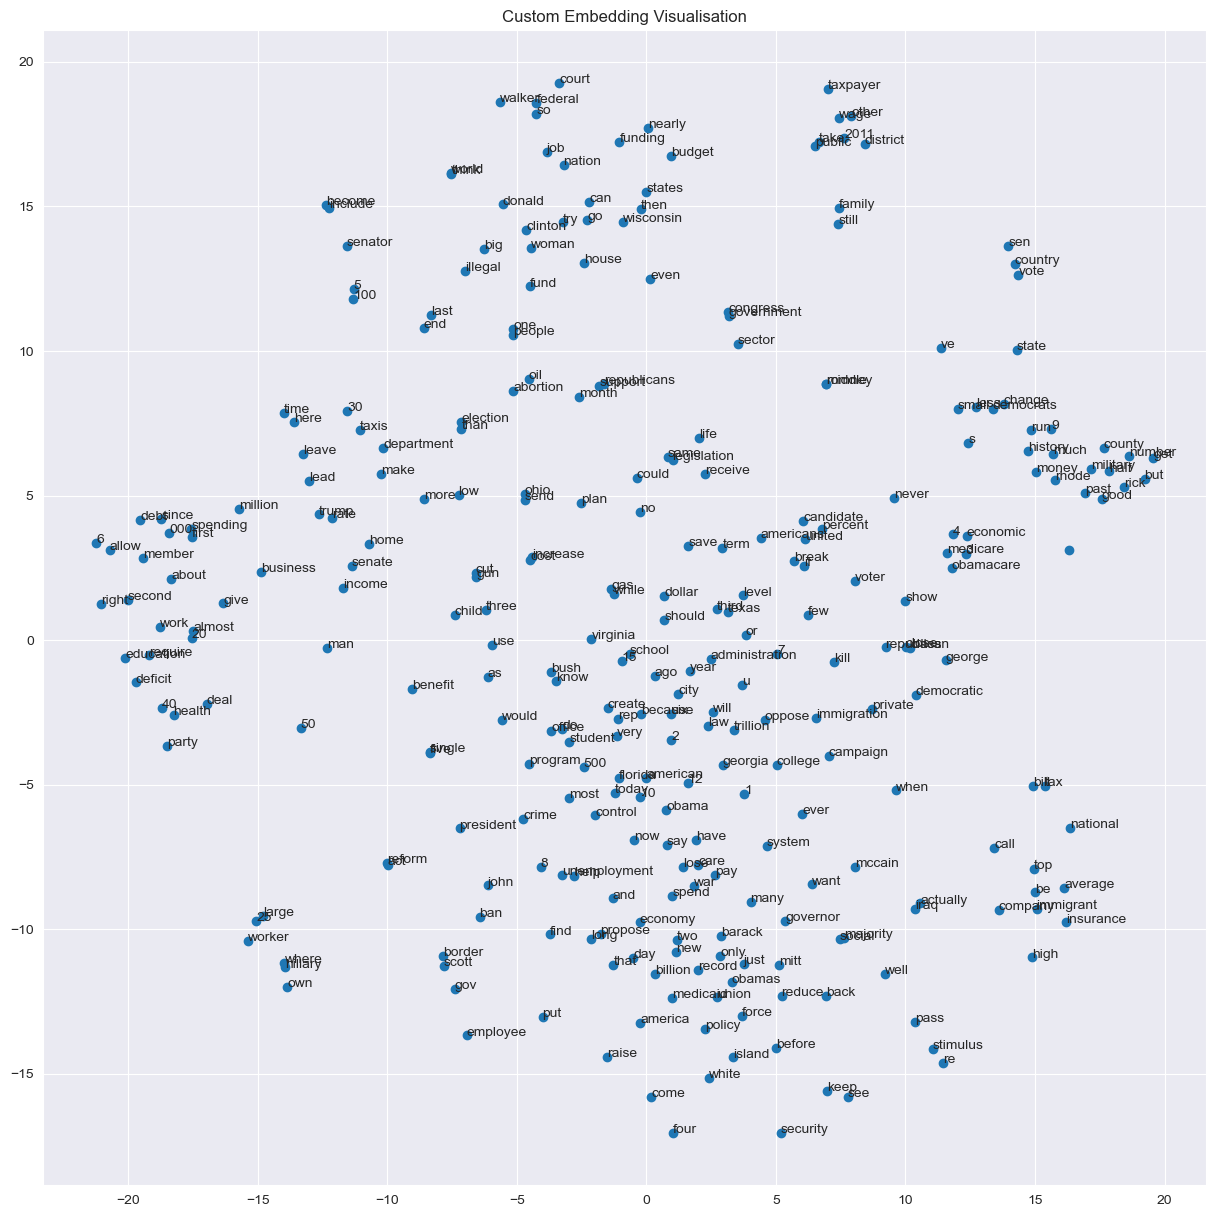

In [95]:
visualize_embeddings(embedding_matrix_custom,
                     vocabulary_dict_custom,
                     num_words=300,
                     plot_title='Custom Embedding Visualisation')


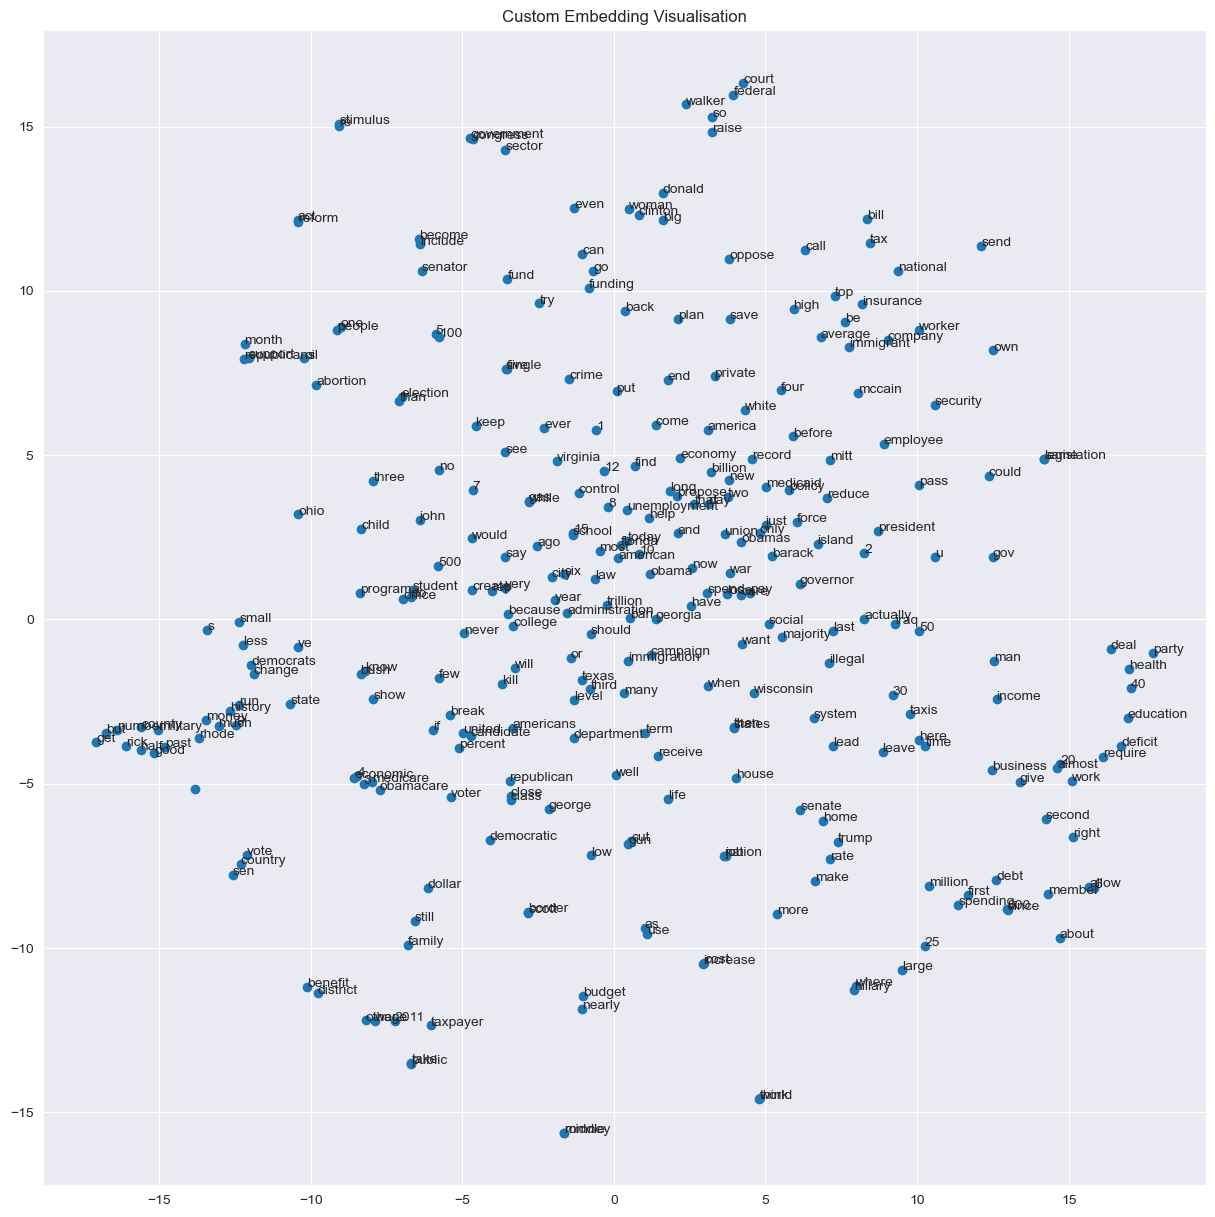

In [97]:
visualize_embeddings(embedding_matrix_custom_300d,
                     vocabulary_dict_custom,
                     num_words=300,
                     plot_title='Custom Embedding Visualisation')


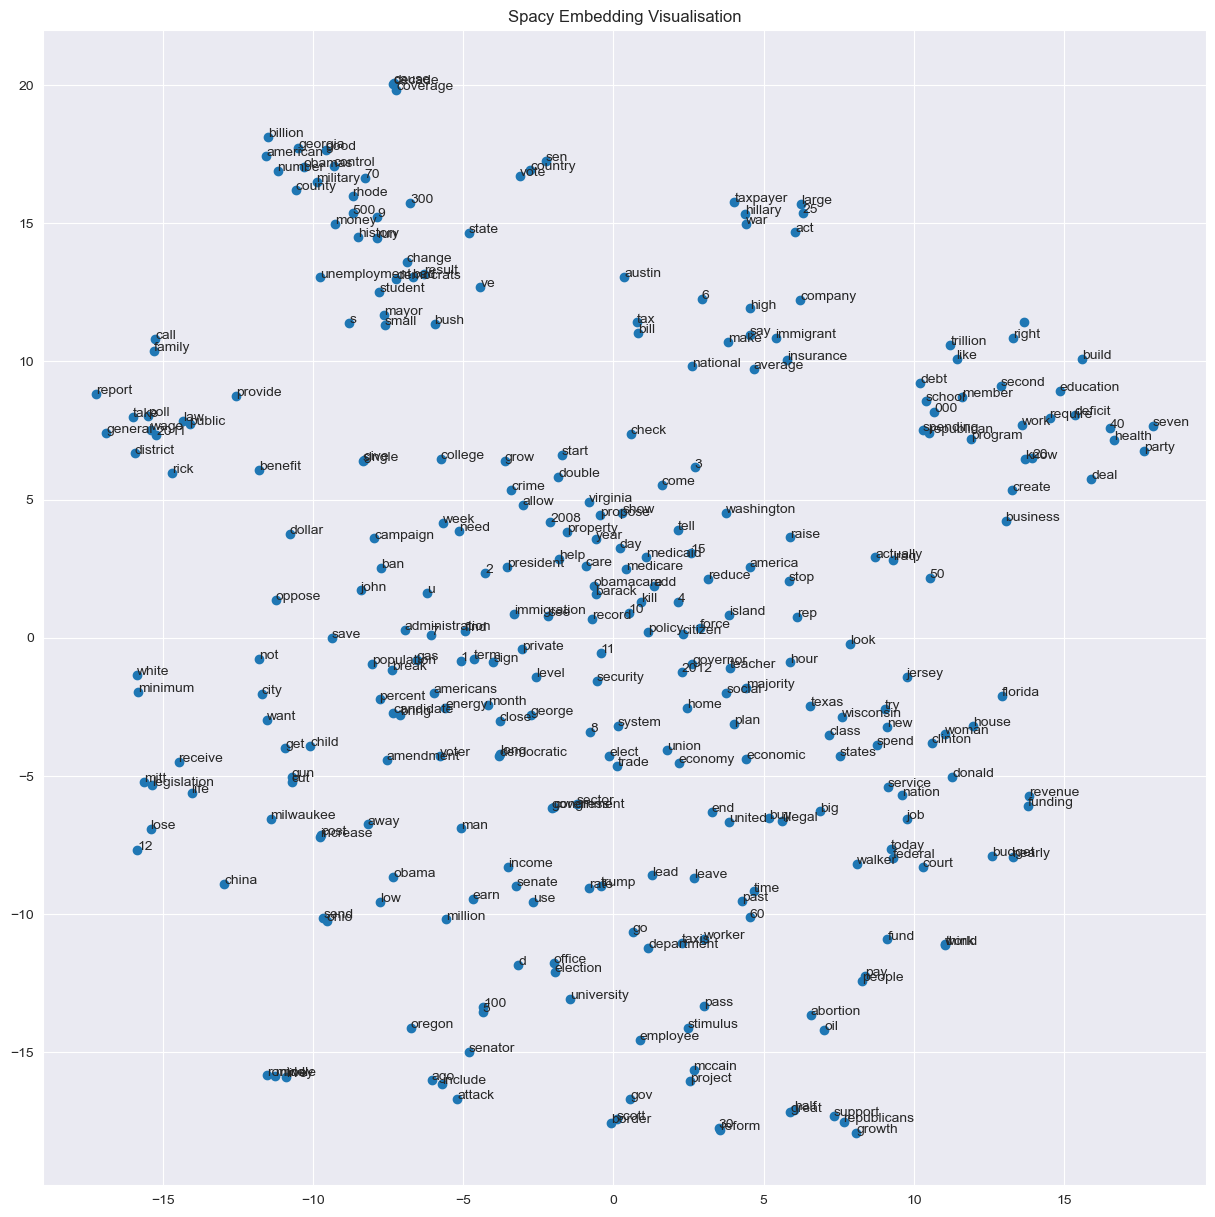

In [96]:
visualize_embeddings(embedding_matrix_spacy,
                     vocabulary_dict_spacy,
                     num_words=300,
                     plot_title='Spacy Embedding Visualisation')

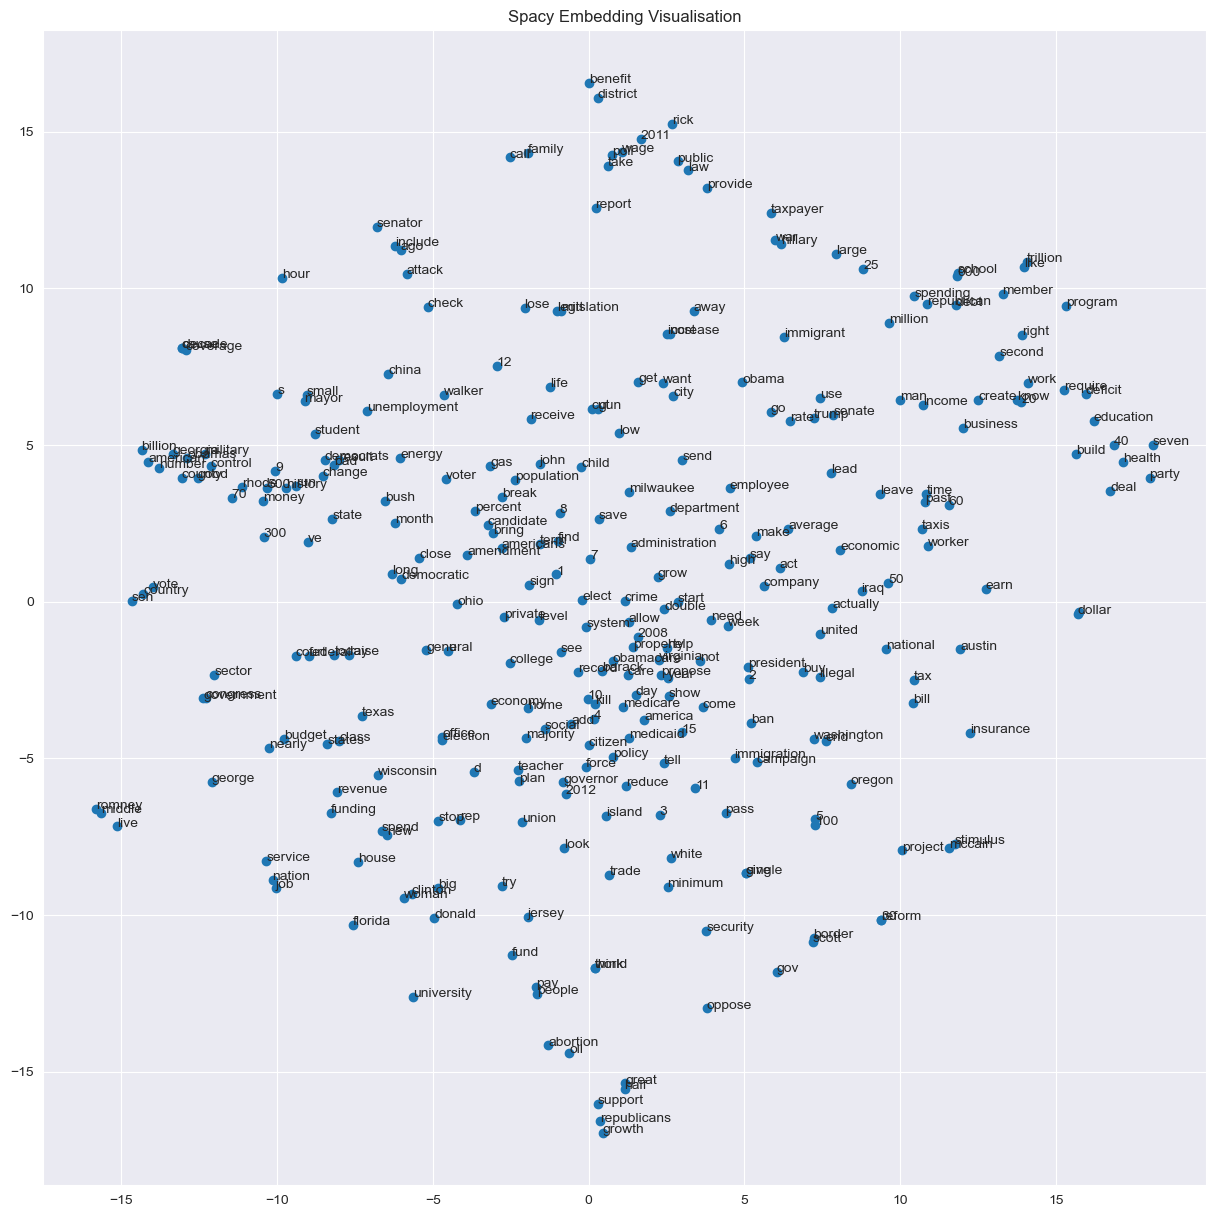

In [98]:
visualize_embeddings(embedding_matrix_spacy_300d,
                     vocabulary_dict_spacy,
                     num_words=300,
                     plot_title='Spacy Embedding Visualisation')

In [109]:
from wordcloud import WordCloud

def plot_word_cloud(vocabulary):

    ## Generate word cloud
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          max_words=500
                          ).generate_from_frequencies(vocabulary)

    ## Display word cloud
    plt.figure(figsize=(24,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

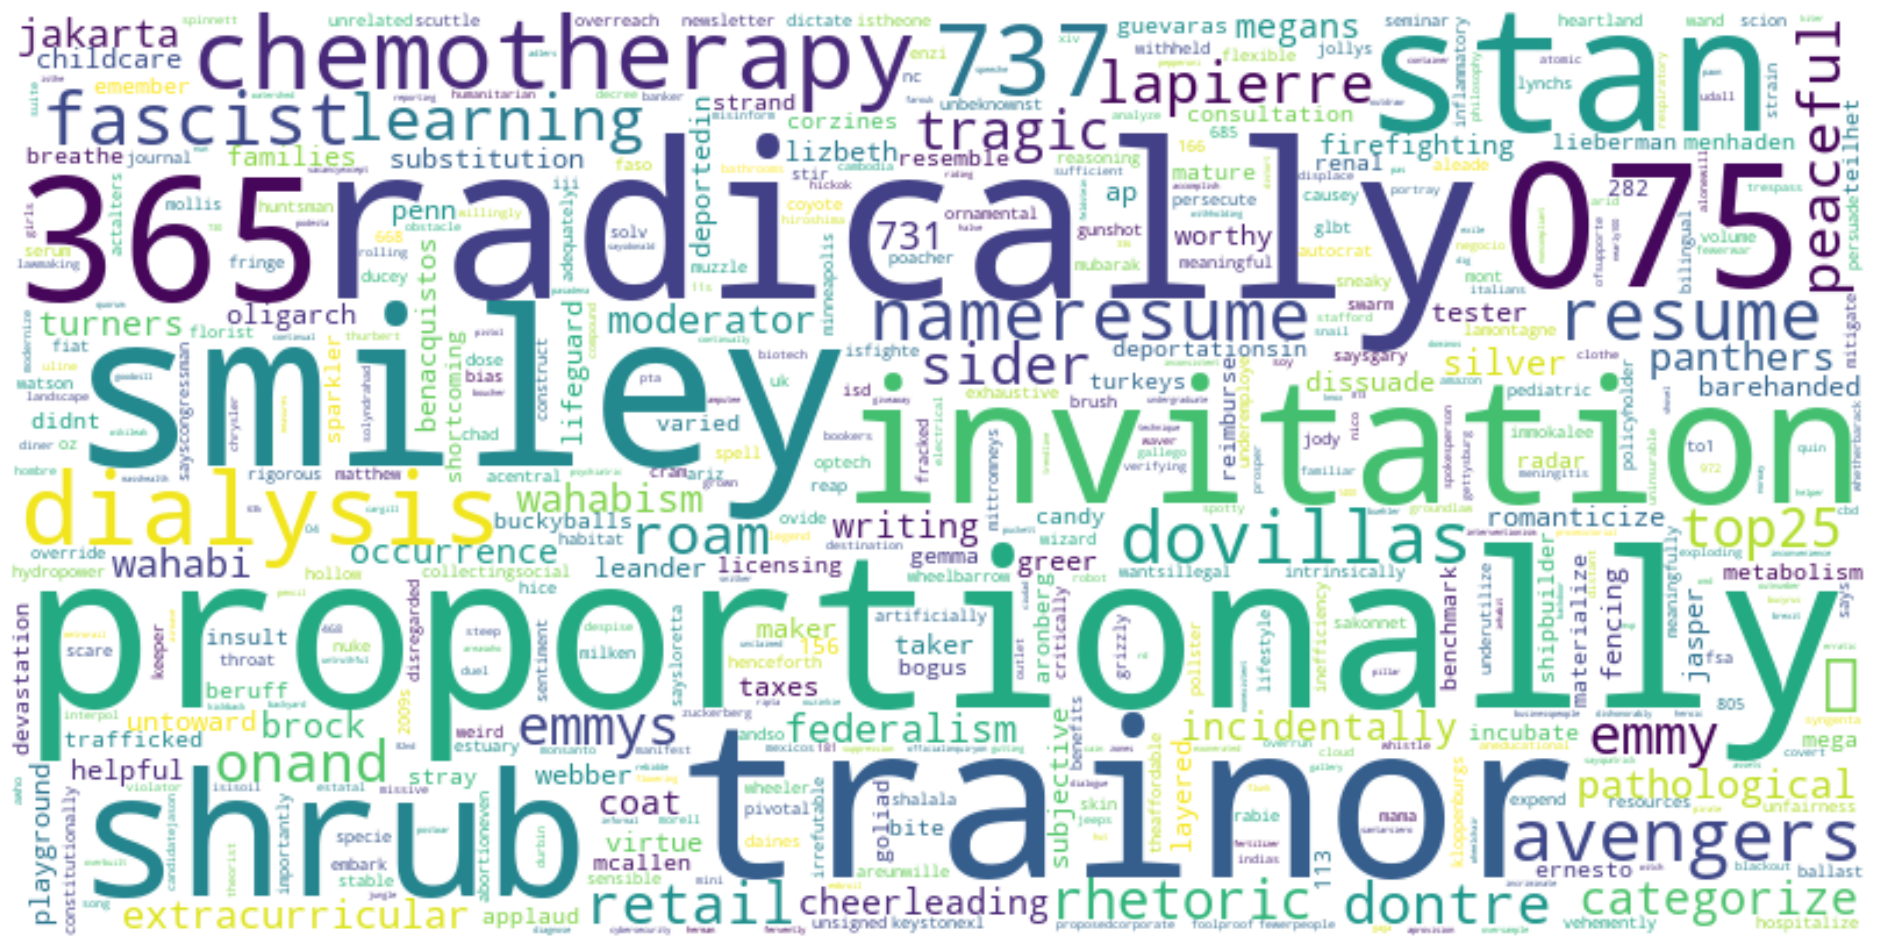

In [110]:
plot_word_cloud(vocabulary_dict_custom)

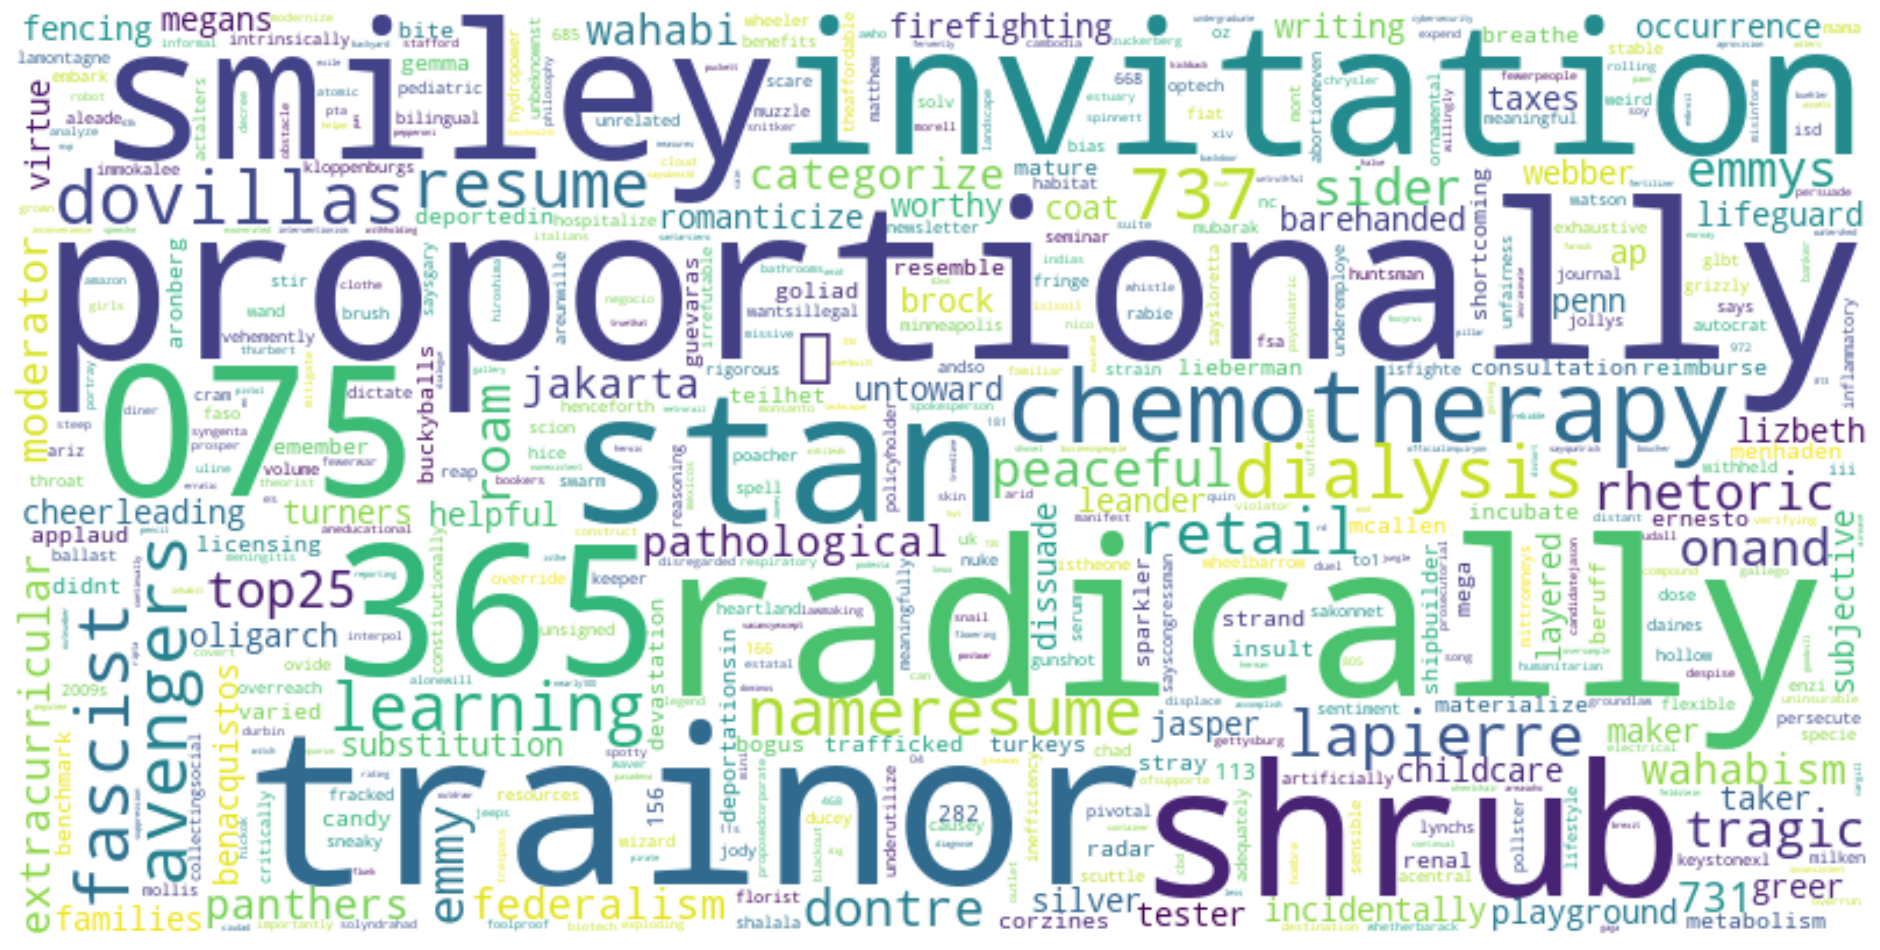

In [111]:
plot_word_cloud(vocabulary_dict_spacy)

#### TODO mar 27
  -  [x] wish mom happy birthday
  -  [ ] separate models into custom and spacy
  -  [ ] decide function vs code cells
  -  [x] cleanup preprocessing
  -  [x] initialise pos tag input
  -  [x] separate notebook into preprocess and model
  -  [x] export data as csv
  -  [x] manage imports


#### Model
1. [ ] if-else vs dictionary?
2. [ ] Train() function

In [102]:
# frequency of most common words in statement_custom
from collections import Counter
cnt = Counter()
for text in train_data["statement_custom"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

[('be', 5642),
 ('have', 3007),
 ('say', 2883),
 ('and', 2851),
 ('year', 1234),
 ('percent', 1190),
 ('state', 1105),
 ('more', 938),
 ('do', 905),
 ('that', 793),
 ('obama', 747),
 ('tax', 706),
 ('job', 650),
 ('president', 647),
 ('million', 639),
 ('vote', 614),
 ('health', 614),
 ('people', 603),
 ('would', 572),
 ('care', 518),
 ('one', 513),
 ('will', 505),
 ('pay', 499),
 ('go', 496),
 ('new', 468),
 ('bill', 462),
 ('time', 441),
 ('or', 439),
 ('get', 436),
 ('billion', 429),
 ('country', 429),
 ('u.s.', 425),
 ('cut', 424),
 ('when', 413),
 ('texas', 393),
 ('take', 385),
 ('only', 383),
 ('law', 379),
 ('taxis', 376),
 ('high', 373),
 ('government', 373),
 ('budget', 370),
 ('rate', 369),
 ('federal', 364),
 ('make', 362),
 ('barack', 358),
 ('since', 352),
 ('if', 345),
 ('now', 337),
 ('school', 333)]

In [103]:
# frequency of most common words in statement_spacy
from collections import Counter
cnt = Counter()
for text in train_data["statement_spacy"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

[('say', 2788),
 ('$', 1280),
 ('year', 1234),
 ('percent', 1190),
 ('state', 1105),
 ('obama', 747),
 ('tax', 706),
 ('job', 650),
 ('president', 647),
 ('million', 639),
 ('vote', 614),
 ('health', 614),
 ('people', 603),
 ('not', 538),
 ('care', 518),
 ('pay', 499),
 ('new', 468),
 ('bill', 462),
 ('time', 441),
 ('billion', 429),
 ('country', 429),
 ('u.s.', 425),
 ('cut', 424),
 ('texas', 393),
 ('law', 379),
 ('taxis', 376),
 ('high', 373),
 ('government', 373),
 ('budget', 370),
 ('rate', 369),
 ('federal', 365),
 ('go', 361),
 ('barack', 358),
 ('school', 333),
 ('support', 330),
 ('plan', 326),
 ('united', 311),
 ('increase', 310),
 ('states', 309),
 ('cost', 298),
 ('spend', 287),
 ('raise', 282),
 ('wisconsin', 280),
 ('take', 274),
 ('money', 263),
 ('clinton', 259),
 ('republican', 256),
 ('work', 254),
 ('s', 248),
 ('1', 246)]

# MODEL
* [x] transfer to bilstm.ipynb